Разведочный анализ данных датасета https://doi.org/10.48804/K3VSND

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import librosa
from IPython.display import Image
import urllib.request

In [2]:
urls = [
    "https://rdr.kuleuven.be/api/access/datafile/135611?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/41029?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/137071?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/41033?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/41032?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/41034?gbrecs=true",
    "https://rdr.kuleuven.be/api/access/datafile/137075?gbrecs=true"
]
with open("urls.txt", "w") as text_file:
    for url in urls:
        text_file.write(url + "\n")

In [3]:
file_names = ["dataset_description.json", "participants_description.json", "participants.tsv", 
             "task_listening_eeg.json", "task_listening_events.json", "task_listening_stimulation.json",
             "task_restingstate_events.json"]
with open("urls.txt", "r") as urls:
    lines = urls.readlines()
    for line, name in zip(lines, file_names):
        urllib.request.urlretrieve(line, name)

In [4]:
for name in [file_name for file_name in file_names if file_name != "participants.tsv"]:
    with open(name, "r") as file:
        print("--" * 20)
        print(f"Описание файла {name}")
        print(json.dumps(json.load(file), indent=4))

----------------------------------------
Описание файла dataset_description.json
{
    "Name": "SparrKULee",
    "BIDSVersion": "1.8.0",
    "DatasetType": "raw",
    "Authors": [
        "Bernd Accou",
        "Lies Bollens",
        "Marlies Gillis",
        "Wendy Verheijen",
        "Hugo Van hamme",
        "Tom Francart"
    ],
    "AuthorsEmail": [
        "bernd.accou@kuleuven.be",
        "lies.bollens@kuleuven.be",
        "marlies.gillis@kuleuven.be",
        "wendy.verheijen@kuleuven.be",
        "hugo.vanhamme@esat.kuleuven.be",
        "tom.francart@kuleuven.be"
    ],
    "License": "Attribution-NonCommercial 4.0 International License (CC BY-NC 4.0) for the EEG data. Stimuli can only be used for non-commercial purposes.",
    "Acknowledgements": "Amelie Algoet, Jolien Smeulders, Lore Kerkhofs, Sara Peeters, Merel Dillen, Ilham Gamgami, Amber Verhoeven, Vitor Vasconselos, Jard Hendrickx, Lore Verbeke and Ana Carbajal Chavez",
    "Funding": [
        "KU Leuven Special Re

**Основные моменты:** Для измерения ЭЭГ были приглашены участники обоих полов. Участникам было указано прослушать аудиофайл. Измерение 64-канального ЭЭГ было совершено с частотой дискретизации равным 8192.

---

### Участники эксперимента 

Дальше проанализируем выборку участников. 

In [11]:
participants = pd.read_csv('./participants.tsv', sep='\t')
participants = participants[['participant_id', 'age', 'sex', 'native_language', 'handedness']]
participants.head()

,participant_id,age,sex,native_language,handedness
0,sub-001,21 to 23,F,"Dutch, Flemish",right
1,sub-002,18 to 20,F,"Dutch, Flemish",right
2,sub-003,18 to 20,F,"Dutch, Flemish",right
3,sub-004,18 to 20,F,"Dutch, Flemish",right
4,sub-005,18 to 20,F,"Dutch, Flemish",right


В выборке имеется 85 участников.

In [12]:
participants['age'].unique()

array(['21 to 23', '18 to 20', '24 to 26', '27 to 30'], dtype=object)

Приглашенные участники делились на 4 возрастные группы.

Число женщин:  74
Число мужчин:  11


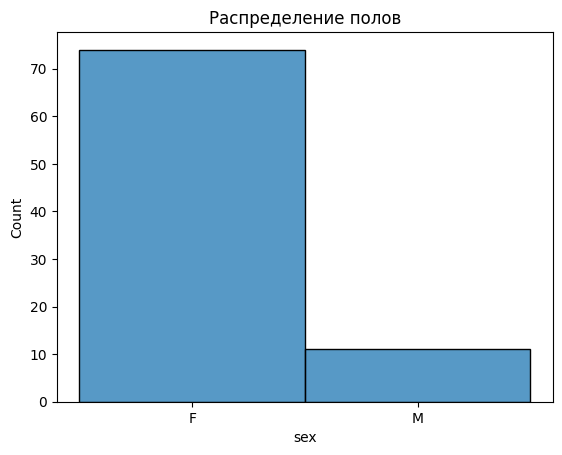

In [13]:
plt.title('Распределение полов')
sns.histplot(participants['sex']);
print('Число женщин: ', np.sum(participants['sex'] == 'F'))
print('Число мужчин: ', np.sum(participants['sex'] == 'M'))

Выделим одинаковое количество женщин и мужчин, чтобы предотвратить переобучение. 

Индексы мужчин

In [15]:
males = participants[participants['sex'] == 'M']
males

,participant_id,age,sex,native_language,handedness
13,sub-014,21 to 23,M,"Dutch, Flemish",right
16,sub-017,18 to 20,M,"Dutch, Flemish",left
20,sub-021,18 to 20,M,"Dutch, Flemish",right
23,sub-024,18 to 20,M,"Dutch, Flemish",right
28,sub-029,18 to 20,M,"Dutch, Flemish",ambidexter
29,sub-030,21 to 23,M,"Dutch, Flemish",right
32,sub-033,21 to 23,M,"Dutch, Flemish",right
61,sub-062,21 to 23,M,"Dutch, Flemish",right
72,sub-073,21 to 23,M,"Dutch, Flemish",right
74,sub-075,24 to 26,M,"Dutch, Flemish",right


Случайно возьмем 11 женщин.

In [16]:
females = participants[participants['sex'] == 'F'].sample(n=11, random_state=42)
females

,participant_id,age,sex,native_language,handedness
4,sub-005,18 to 20,F,"Dutch, Flemish",right
71,sub-072,21 to 23,F,"Dutch, Flemish",right
21,sub-022,21 to 23,F,"Dutch, Flemish",right
0,sub-001,21 to 23,F,"Dutch, Flemish",right
35,sub-036,24 to 26,F,"Dutch, Flemish",right
84,sub-085,21 to 23,F,"Dutch, Flemish",right
10,sub-011,21 to 23,F,"Dutch, Flemish",right
41,sub-042,18 to 20,F,"Dutch, Flemish",right
12,sub-013,21 to 23,F,"Dutch, Flemish",right
63,sub-064,21 to 23,F,"Dutch, Flemish",right


По итогу будем работать со следующим датасетом. 

In [20]:
res = pd.concat([males, females])
res.sort_index()

,participant_id,age,sex,native_language,handedness
0,sub-001,21 to 23,F,"Dutch, Flemish",right
4,sub-005,18 to 20,F,"Dutch, Flemish",right
10,sub-011,21 to 23,F,"Dutch, Flemish",right
12,sub-013,21 to 23,F,"Dutch, Flemish",right
13,sub-014,21 to 23,M,"Dutch, Flemish",right
16,sub-017,18 to 20,M,"Dutch, Flemish",left
20,sub-021,18 to 20,M,"Dutch, Flemish",right
21,sub-022,21 to 23,F,"Dutch, Flemish",right
23,sub-024,18 to 20,M,"Dutch, Flemish",right
28,sub-029,18 to 20,M,"Dutch, Flemish",ambidexter


Для эксперимента были использованы следующие стимулы:
- Подкасты: `1-12`, `24-37`
- Аудиокниги: `1`, `1_1-2`, `2_1-2`, `3`, `4`, `5_1-3`, `6_1-2`, `7_1-6`, `8_1-2`, `9_1-2`, `13_1-2`, `14_1-2`

В аудиокнигах обозначение,например, `1_1-2` значит, что были взяты аудиокниги `1_1` и `1_2`. Подробнее про стимулы ниже.

### Стимулы

Изображения взяты из соответствующей статьи. 

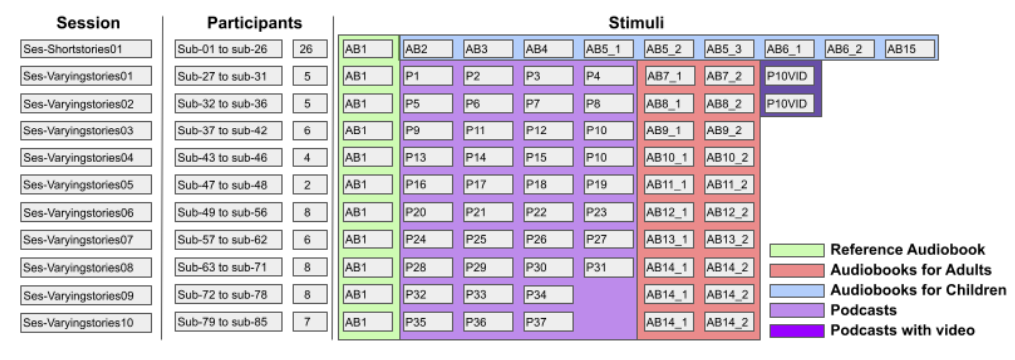

In [8]:
Image("../figures/presented_stimuli.png")

Все участники прослушали 6, 7, 8 или 10 стимулов, каждая из которых имеет примерную продолжительность 15 мин. 
После прослушивания участников спрашивали про содержания аудиофрагмента. Это было с целью мотивировать участников обращать внимания во время прослушивания.

Стимулы были разделены на следующие категории:
- Референсные аудиокниги 
- Аудиокниги для детей и взрослых. Если длина превышала 15 мин, то аудиокнига делилась на части
- Аудиокниги с шумом
- Подкасты про ответы на научные вопросы
- Подкасты с видео

Также отметим, согласно авторам, что частота дискретизации ЭЭГ и стимулов была занижена до 64 Гц. 

In [1]:
import os, os.path
dataset_folder = "/home/bukkacha/Desktop/EEGDataset"
eeg_folder = os.path.join(dataset_folder, "derivatives/preprocessed_eeg")
counter = 0
for sub in os.listdir(eeg_folder):
    path_sub = os.path.join(eeg_folder, sub)
    if os.path.isdir(path_sub):
        ses = os.listdir(path_sub)[0]
        full_path = os.path.join(path_sub, ses)
        files = os.listdir(full_path)
        for file_name in files:
            if "artefact" in file_name:
                print(full_path)
                continue
            counter += 1
        
counter

183

Имеем всего 183 пар. 

### Явный вид данных

На примере конкретного сигнала ЭЭГ и стимула посмотрим какими данными мы будем работать.

In [17]:
# весит 30 Мб
urllib.request.urlretrieve("https://rdr.kuleuven.be/api/access/datafile/136276?gbrecs=true", 
                           "sub_001_audiobook_1_eeg.npy");
urllib.request.urlretrieve("https://rdr.kuleuven.be/api/access/datafile/137157?gbrecs=true", 
                           "audiobook_1_envelope.npy");

In [2]:
eeg = np.load("sub_001_audiobook_1_eeg.npy")
env_stim = np.load("audiobook_1_envelope.npy")

In [19]:
eeg

array([[ 2.91190144,  5.24515395,  6.85442542, ..., -4.1788156 ,
        -1.64721922, -4.1297108 ],
       [ 1.28761259,  2.65540489,  4.21729422, ...,  1.15973719,
         2.25994515, -0.44296132],
       [ 1.68444295,  2.14982537,  2.0341486 , ..., -1.61322093,
        -0.05149848, -1.58436349],
       ...,
       [-1.22009992, -3.32514724,  2.3351159 , ..., -3.00936608,
         0.01443311, -2.05622155],
       [-0.9120842 , -2.63914438,  0.7126077 , ..., -2.1028855 ,
         0.08387135,  0.85487463],
       [-1.84572973, -4.65242521, -0.25433346, ..., -3.46189679,
         0.82149176, -2.46507728]])

In [9]:
eeg.shape

(64, 60096)

Как видим у ЭЭГ 64 канала и продолжительность $\frac{60096}{64 \cdot 60} \approx 15$ минут.

In [10]:
env_stim

array([[0.00421509],
       [0.01188228],
       [0.00744389],
       ...,
       [0.00770379],
       [0.0088369 ],
       [0.00483418]])

In [11]:
env_stim.shape

(59958, 1)

А стимул представляет собой временной ряд длительностью тоже $\frac{59958}{64 \cdot 60} \approx 15$ минут.

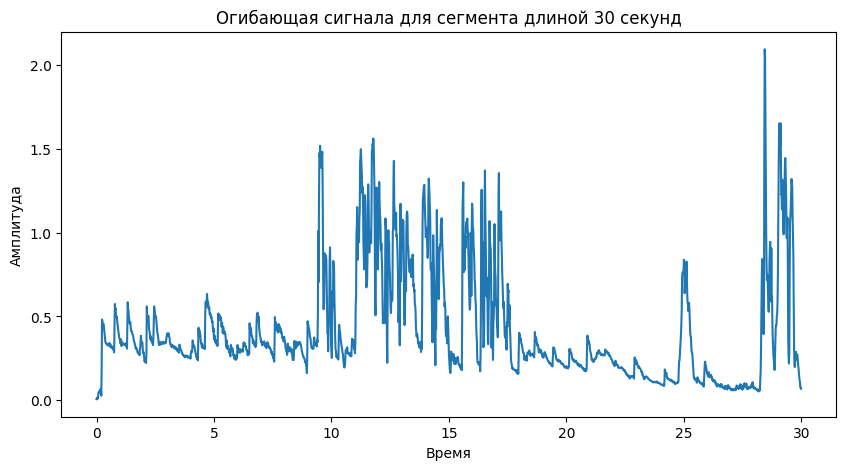

In [27]:
plt.figure(figsize=(10, 5))
plt.title('Огибающая сигнала для сегмента длиной 30 секунд')
plt.plot(np.arange(len(env_stim[:64*60//2])) / 64, env_stim[:64*60//2]);
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.show()

In [21]:
eeg[0].shape

(60096,)

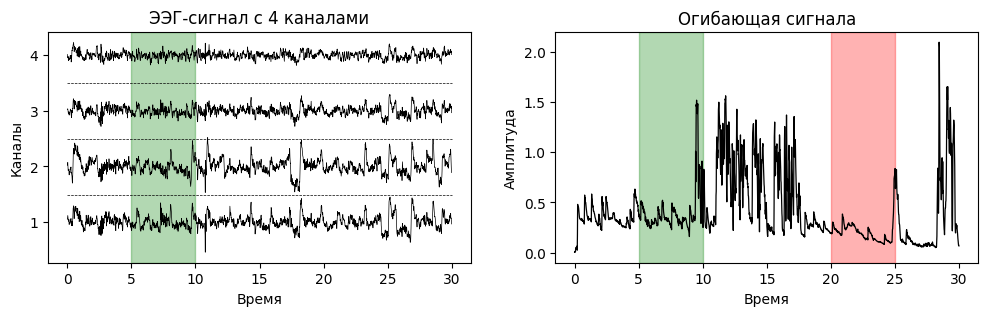

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

#eeg
t = np.arange(len(eeg[0][:64*60//2])) / 64
ax[0].set_title("ЭЭГ-сигнал с 4 каналами")
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Каналы")
factor = 0.3
dy = (eeg.max() - eeg.min()) * factor
ax[0].set_yticks([0, dy, 2*dy, 3*dy], labels=[1, 2, 3, 4])
ax[0].hlines([dy//2, 3*dy//2, 5*dy//2], xmin=0, xmax=30,
            linestyle="--", color='black', linewidth=0.5)
for i, eeg_row in enumerate(eeg[:4]):
    ax[0].plot(t, eeg_row[:64*30] + i * dy, color='black', linewidth=0.5)
ax[0].axvspan(5, 10, color='g', alpha=0.3)

#audio
t = np.arange(len(env_stim[:64*60//2])) / 64
ax[1].set_title("Огибающая сигнала")
ax[1].set_xlabel("Время")
ax[1].set_ylabel("Амплитуда")
ax[1].plot(t, env_stim[:64*60//2], color='black', linewidth=0.9)
ax[1].axvspan(5, 10, color='green', alpha=0.3)
ax[1].axvspan(20, 25, color="red", alpha=0.3)

plt.show()

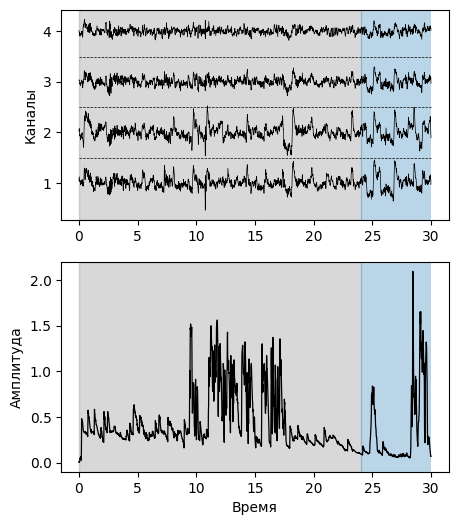

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(5, 6))

#eeg
t = np.arange(len(eeg[0][:64*60//2])) / 64
ax[0].set_ylabel("Каналы")
factor = 0.3
dy = (eeg.max() - eeg.min()) * factor
ax[0].set_yticks([0, dy, 2*dy, 3*dy], labels=[1, 2, 3, 4])
ax[0].hlines([dy//2, 3*dy//2, 5*dy//2], xmin=0, xmax=30,
            linestyle="--", color='black', linewidth=0.5)
for i, eeg_row in enumerate(eeg[:4]):
    ax[0].plot(t, eeg_row[:64*30] + i * dy, color='black', linewidth=0.5)
ax[0].axvspan(0, 0.8 * 30, color='grey', alpha=0.3)
ax[0].axvspan(0.8 * 30, 30, alpha=0.3)
# ax[0].set_xticks([0, dy, 2*dy, 3*dy])

#audio
t = np.arange(len(env_stim[:64*60//2])) / 64
ax[1].set_xlabel("Время")
ax[1].set_ylabel("Амплитуда")
ax[1].plot(t, env_stim[:64*60//2], color='black', linewidth=0.9)
ax[1].axvspan(0, 0.8 * 30, color='grey', alpha=0.3)
ax[1].axvspan(0.8 * 30, 30, alpha=0.3)

# fig.tight_layout(h_pad=1)
plt.show()

In [97]:
# весит 70 Мб
urllib.request.urlretrieve("https://rdr.kuleuven.be/api/access/datafile/37109?gbrecs=true", 
                           "audiobook_1.npz.gz")
!gzip -d audiobook_1.npz.gz
audiobook_1 = np.load("audiobook_1.npz")
audio = audiobook_1['audio']
fs = audiobook_1['fs'].item()

In [98]:
audio.shape

(44967811,)

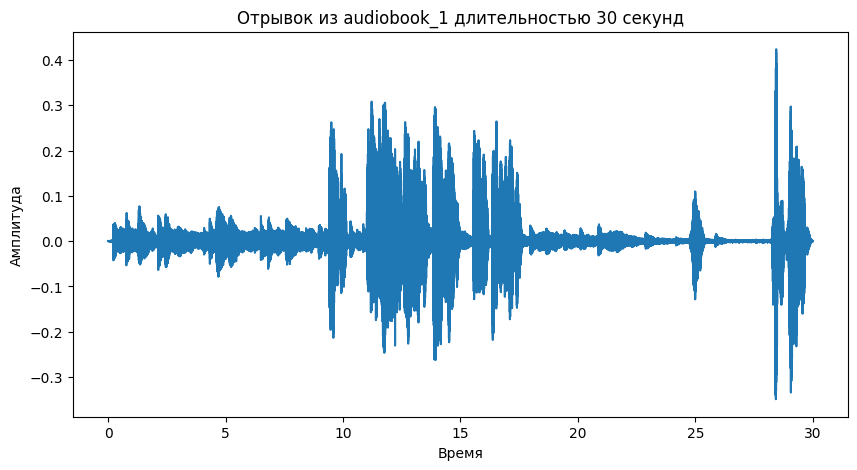

In [99]:
plt.figure(figsize=(10, 5))
plt.title('Отрывок из audiobook_1 длительностью 30 секунд')
plt.plot(np.arange(len(audio[:fs*60//2])) / fs, audio[:fs*60//2])
plt.ylabel('Амплитуда')
plt.xlabel('Время')
plt.show()

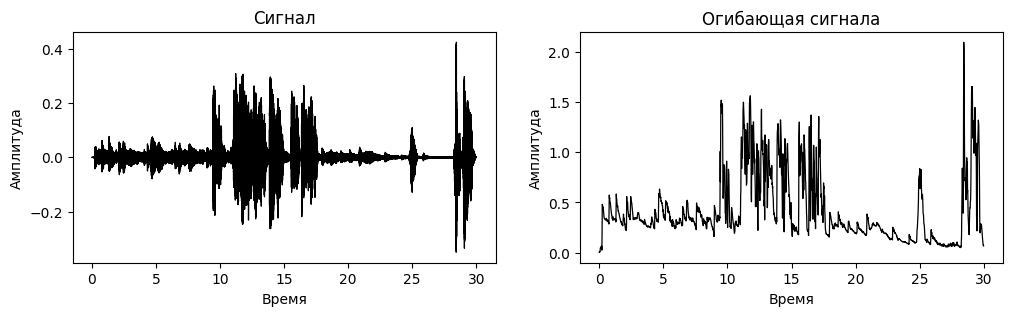

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

#raw audio
t = np.arange(len(audio[:fs*60//2])) / fs
ax[0].set_title("Сигнал")
ax[0].set_xlabel("Время")
ax[0].set_ylabel("Амплитуда")
ax[0].plot(t, audio[:fs*60//2], color='black', linewidth=0.9)

#audio
t = np.arange(len(env_stim[:64*60//2])) / 64
ax[1].set_title("Огибающая сигнала")
ax[1].set_xlabel("Время")
ax[1].set_ylabel("Амплитуда")
ax[1].plot(t, env_stim[:64*60//2], color='black', linewidth=0.9)

plt.show()

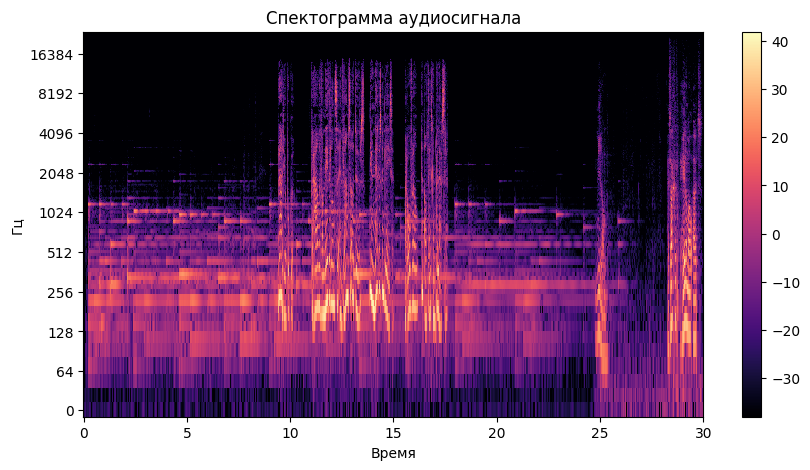

In [36]:
X = librosa.stft(audio[:fs * 60//2])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10, 5))
librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='log')
plt.title("Спектограмма аудиосигнала")
plt.colorbar()
plt.xlabel('Время')
plt.ylabel('Гц')
plt.show()

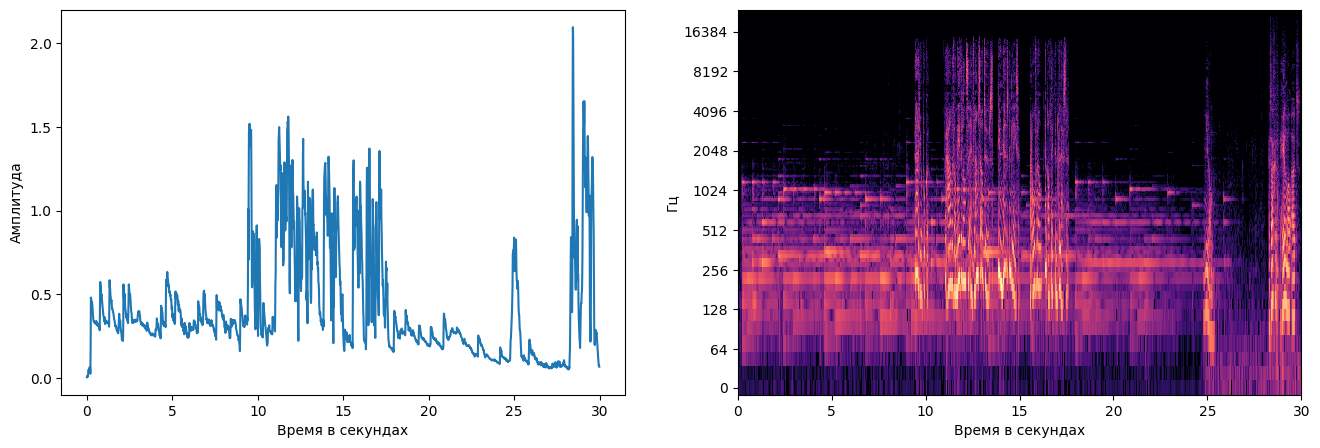

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
ax[0].plot(np.arange(len(env_stim[:64*60//2])) / 64, env_stim[:64*60//2]);
X = librosa.stft(audio[:fs * 60//2])
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='log', ax=ax[1])
ax[0].set_xlabel('Время в секундах')
ax[0].set_ylabel('Амплитуда')
ax[1].set_xlabel('Время в секундах')
ax[1].set_ylabel('Гц')
plt.show()

# Clean up files

In [25]:
for file in file_names + ["audiobook_1_envelope.npy", "sub_001_audiobook_1_eeg.npy", "urls.txt", 
                          "audiobook_1.npz"]:
    !rm {file}

rm: cannot remove 'audiobook_1_envelope.npy': No such file or directory
rm: cannot remove 'sub_001_audiobook_1_eeg.npy': No such file or directory
rm: cannot remove 'audiobook_1.npz': No such file or directory
